In [ ]:
#!pip install tensorflow matplotlib numpy

# Implementing GAN using Tensorflow 2.0
- https://medium.com/aubergine-solutions/implementing-gan-using-tensorflow-2-0-9d03e29692cf
- https://gist.github.com/TheBojda/9e67906ec478c8c005fb23f768a5e48b
- https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

```
# MINST GAN Example
# based on https://www.tensorflow.org/tutorials/generative/dcgan
```

In this article, we’ll understand how to implement Generative Adversarial Networks in Tensorflow 2.0 using the MNIST dataset of digits. Our model should be able to accurately create images similar to MNIST dataset images. Image from MNIST dataset looks like this:

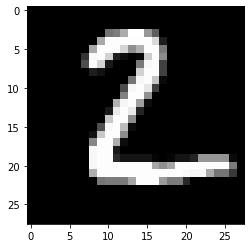

## Prerequisites
Before moving ahead please make sure you are updated with the following requirements:

1. Basic understanding of Tensorflow 2.0
2. Basic understanding of GANs
3. Tensorflow 2.0 library with Python 3.6

Let’s jump into code directly

For implementing the network, we need to follow the following steps.

## Step 1: Import Libraries
We will need to import these libraries.



In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

import os
from tensorflow.keras import layers
from IPython import display

## Step 2: Load and Prepare data
In this piece of code, we imported data and reshaped it. Images are represented in the values between 0 to 255. So these image vectors are converted into values between [-1, 1]. Then these vectors are shuffled and converted to batches of 256 images.

In [3]:
(train_images, train_labels),(test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


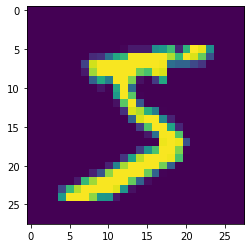

In [4]:
plt.imshow(train_images[0])

In [5]:
train_images[0].shape

(28, 28)

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')

In [8]:
train_images.shape

(60000, 28, 28, 1)

In [9]:
train_images = (train_images-127.5)/127.5

In [10]:
BUFFER_SIZE = train_images.shape[0] # 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

## Step 3: Create Models



# Generator
The generator model will take vector of <font color='red'>100 pixels</font> as input and convert that **vector** into an image of 26 * 26 using the Conv2DTranspose layer. As we are using convolutions, this model will be a DCGAN i.e. Deep Convolutional Generative Adversarial Network.

**BatchNormalization** layer is used for normalizing the generated image to reduce noise that image. The activation function of “**ReLU**” is added as another layer in the model.

In [12]:
def create_generator():
    model = tf.keras.Sequential()
    
    # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [18]:
generator = create_generator()

In [22]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

Now that we have our generator network, we can easily generate a sample image with the following code:

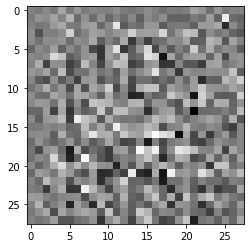

In [23]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')




### Discriminator Model
Discriminator will do the exact opposite of a generator and convert image into scalar probabilities of whether the image is fake or real. It will use the Conv2D layer for this purpose. Along with the convolutional layer, it will have layer of an activation function “ReLU” and the Dropout layer.

In [13]:
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [19]:
discriminator = create_discriminator()

In [21]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Finally, we can check what our non-trained discriminator says about the sample generated by the non-trained generator:

In [24]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00111323]], shape=(1, 1), dtype=float32)


After both the models are created, we’ll move to the next steps.



## Step 4: Define Loss and Optimizers
Here, we’re using **BinaryCrossentropy** from tf.keras.losses API. Using this cross_entropy loss, we’ll make loss functions for discriminator and generator.

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Now, we’ll create optimizers for generator and discriminator using <font color='red'>Adam</font> optimizer from <font color='red'>tf.keras.optimizers</font> API with a learning rate of 1e-4.



In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
'''
def get_discriminator_loss(real_prediction, fake_prediction):
    real_prediction = tf.sigmoid(real_prediction)
    fake_prediction = tf.sigmoid(fake_prediction)
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_prediction),real_prediction)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_prediction),fake_prediction)
    return real_loss + fake_loss
    
def get_generator_loss(fake_prediction):
    fake_prediction = tf.sigmoid(fake_prediction)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_prediction),fake_prediction)
    return fake_loss
'''

## Set the Checkpoints

In [28]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Step 5: Define Training functions
Initially, the generator will generate an image with only random pixels and as time passes, it will make images that are almost similar to the training images. Image from the generator before training looks like the following:
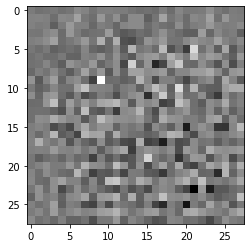

In [33]:
noise_dim = 100  # = input_size 输入尺寸
num_of_generated_examples = 16
EPOCHS = 10 #60

seed = tf.random.normal([num_of_generated_examples, noise_dim])

First, we need to create noise data for passing into the generator model. Then create a function to learn through iterations using the concept of Eager Execution. Please refer to [this](https://www.youtube.com/watch?v=T8AW0fKP0Hs) for understanding what is Eager Execution as it is out of scope for this tutorial.

In [34]:
@tf.function
def train_step(images):
    # 1 - Create a random noise to feed it into the model for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = G_loss(fake_output)
      disc_loss = D_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

GradientTape above is used for creating gradients as we go further and these gradients are applied to optimizers for decreasing the loss function.



In [35]:
def train_GAN(dataset, epochs):
    # A. For each epoch, do the following:
    for epoch in range(epochs):
        start = time.time()
        # 1 - For each batch of the epoch, 
        for image_batch in dataset:
            # 1.a - run the custom "train_step" function
            # we just declared above
            train_step(image_batch)

        # 2 - Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

        # 3 - Save the model every 5 epochs as 
        # a checkpoint, which we will use later
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # 4 - Print out the completed epoch no. and the time spent
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # B. Generate a final image after the training is completed
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [36]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

This is the final function to call the train_step function for each batch in the dataset.

Finally, we’ll call our train_GAN function to start training on the image dataset with 500 epochs.

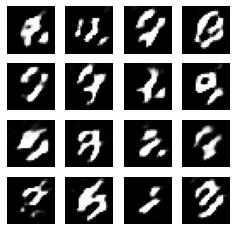

In [37]:
train_GAN(train_dataset, 10)

## Generate Digits
Before generating new images, let's make sure we restore the values from the latest checkpoint with the following line:

In [38]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

We can also view the evolution of our generative GAN model by viewing the generated 4x4 grid with 16 sample digits for any epoch with the following code:

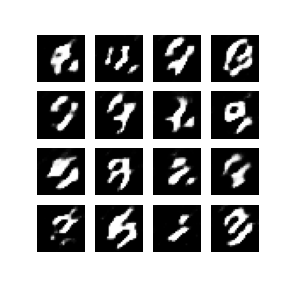

In [39]:
# PIL is a library which may open different image file formats
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

or better yet, let's create a GIF image visualizing the evolution of the samples generated by our GAN with the following code:

In [41]:
!pip install imageio

     |████████████████████████████████| 3.3 MB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


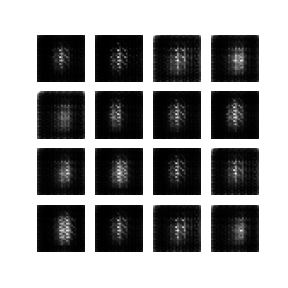

In [42]:
import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)
  
display.Image(open('dcgan.gif','rb').read())